In [ ]:
# Instalar TensorFlow si no está instalado
!pip install tensorflow

In [ ]:
# Importar las bibliotecas necesarias
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import json
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import  ParameterGrid
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuracion
IMG_WIDTH = 224
IMG_HEIGHT = 224
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 64
BUFFER_SIZE = tf.data.AUTOTUNE

# Paths
DATA_PATH = '/content/drive/MyDrive/TFG/Dataset/MVTec' #Data Path
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
MODEL_SAVE_PATH = os.path.join(DATA_PATH, 'models')
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Parámetros
param_grid = {
    'learning_rate': [1e-4],
   # 'optimizer': ['adam', 'sgd'],
    'epochs': [30],
    'batch_size': [32]
}

In [ ]:
# Definir las rutas de las carpetas
viroide_dir = '/content/drive/MyDrive/sunrrise_dataset2/viroide'
sanas_dir = '/content/drive/MyDrive/sunrrise_dataset2/sanas'

# Definir el tamaño de las imágenes y la lista para almacenar las imágenes y etiquetas
img_size = (150, 150)  # Cambia el tamaño según sea necesario
images = []
labels = []



# Función para cargar imágenes
def cargar_imagenes(directorio, etiqueta):
    for img_name in os.listdir(directorio):
        img_path = os.path.join(directorio, img_name)
        img = cv2.imread(img_path)  # Leer imagen
        if img is not None: # Verificar si la imagen se cargó correctamente
            img = cv2.resize(img, img_size)  # Redimensionar imagen
            images.append(img)
            labels.append(etiqueta)
        else:
            print(f"Error al cargar la imagen: {img_path}") # Imprimir un mensaje de error si la imagen no se pudo cargar


# Cargar las imágenes de hojas enfermas (viroide) y sanas
cargar_imagenes(viroide_dir, 1)  # 1 para viroide (enfermas)
cargar_imagenes(sanas_dir, 0)  # 0 para sanas

# Convertir las listas a arrays de NumPy
images = np.array(images)
labels = np.array(labels)

# Normalizar las imágenes a rango [0, 1]
images = images / 255.0

In [ ]:
# Dividir en conjunto de entrenamiento y validación (70% entrenamiento, 30% validación)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)


In [ ]:
def create_model_1(input_shape=(150, 150, 3)):
    base_model = ResNet50V2(
        weights="imagenet", include_top=False, input_shape=input_shape
    )

    # Freeze some layers (adjust as needed)
    for layer in base_model.layers[:100]:  # Freeze the first 100 layers
        layer.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1, activation="sigmoid")(x)  # For binary classification

    model = models.Model(inputs=base_model.input, outputs=x)
    return model


def create_model_2(input_shape=(*image_size, 3)):
    model = keras.Sequential(
        [
             layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),  # Añadir Batch Normalization después de la capa Conv2D
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
        ]
    )
    return model

In [ ]:
model = create_model_1(input_shape=(150, 150, 3))
from keras.optimizers import Adam
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Mostrar resumen del modelo
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 38, 38, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 38, 38, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 40, 40, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 20,561,921 (78.44 MB)

 Non-trainable params: 3,004,928 (11.46 MB)

In [ ]:
model = create_model_2(input_shape=(*image_size, 3))
from keras.optimizers import Adam
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Mostrar resumen del modelo
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,454,529 (13.18 MB)

 Trainable params: 3,453,825 (13.18 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Entrenamiento y evaluación del modelo
def train_and_evaluate_model(model, train_generator, test_generator, epochs, batch_size, learning_rate=1e-3, optimizer='adam'):
    # Recompilar con los parámetros
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator,
    )
    return model, history
optimizers_to_test = ['adam', 'sgd']


#Entrenamiento inicial
best_accuracy = 0.0
best_model = None
best_model_type = None

model_types = ['model_1', 'model_2']

for model_type in model_types:
    print(f"Training {model_type}...")
    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")

        # creación del modelo
        if model_type == 'model_1':
            model = create_model_1()
        elif model_type == 'model_2':
            model = create_model_2()

        # ACA! Añadir modelos adicionales!!

        from tensorflow.keras.preprocessing.image import ImageDataGenerator

        train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
        test_datagen = ImageDataGenerator(rescale=1./255)

        # Assuming 'X_train', 'y_train', 'X_val', 'y_val' are your training and validation data
        train_generator = train_datagen.flow(
            X_train, y_train,
            batch_size=param_grid['batch_size'][0]  # Access batch_size from param_grid
        )

        test_generator = test_datagen.flow(
            X_val, y_val,
            batch_size=param_grid['batch_size'][0]  # Access batch_size from param_grid
        )

        for optimizer in optimizers_to_test:
            print(f"Training with optimizer: {optimizer}")
            # entrenamiento y evaluación
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

            model, history = train_and_evaluate_model(
                model, train_generator, test_generator,
                epochs=params['epochs'], # Pass the integer value of epochs
                batch_size=params['batch_size'],# Pass the integer value of batch_size
                learning_rate=params['learning_rate'],
                optimizer=optimizer # Use the current optimizer
            )


        val_accuracy = history.history['val_accuracy'][-1]

        # Selección del mejor modelo
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_model_type = model_type
            best_params = param_grid

        model_filename = f"{model_type}_lr{param_grid['learning_rate']}_opt{param_grid['optimizer']}.h5"
        model_path = os.path.join(MODEL_SAVE_PATH, model_filename)
        model.save(model_path)
        print(f"Model saved to: {model_path}")

# Guardar mejor modelo
if best_model is not None:
    best_model_path = os.path.join(MODEL_SAVE_PATH, f"best_{best_model_type}_model.h5")
    best_model.save(best_model_path)
    print(f"Best model ({best_model_type}) saved to: {best_model_path} with accuracy: {best_accuracy:.4f}")

Training model_1...
Training with parameters: {'batch_size': 32, 'epochs': 30, 'learning_rate': 0.0001, 'optimizer': 'adam'}
Training with optimizer: adam
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.4619 - loss: 0.8014 - val_accuracy: 0.4444 - val_loss: 1.2110
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.5777 - loss: 0.6814 - val_accuracy: 0.5556 - val_loss: 2.0351
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5649 - loss: 0.7127 - val_accuracy: 0.5556 - val_loss: 1.7472
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.4748 - loss: 0.7129 - val_accuracy: 0.5556 - val_loss: 1.0482
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.4821 - loss: 0.7019 - val_accuracy: 0.5556 - val_loss: 0.6902
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.4933 - loss: 0.7116 - val_accuracy: 0.4444 - val_loss: 2.2905
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6418 - loss: 0.6417 - val_accuracy: 0.4444 - val_loss: 0.8005
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5687 - loss: 0.6632 - val_accuracy: 0.4444 - val_loss: 1.6713
Epoch

Model saved to: /content/drive/MyDrive/TFG/Dataset/MVTec/models/model_1_lr[0.0001]_opt['adam', 'sgd'].h5
Training with parameters: {'batch_size': 32, 'epochs': 30, 'learning_rate': 0.0001, 'optimizer': 'sgd'}
Training with optimizer: adam
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5056 - loss: 0.8009 - val_accuracy: 0.5556 - val_loss: 2.3288
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.4727 - loss: 0.7427 - val_accuracy: 0.5556 - val_loss: 2.4783
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.4899 - loss: 0.7445 - val_accuracy: 0.5556 - val_loss: 2.3696
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.4840 - loss: 0.7163 - val_accuracy: 0.5556 - val_loss: 2.2948
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5570 - loss: 0.6878 - val_accuracy: 0.5556 - val_loss: 1.7232
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.5213 - loss: 0.7032 - val_accuracy: 0.5556 - val_loss: 1.4118
Epoch 7

Model saved to: /content/drive/MyDrive/TFG/Dataset/MVTec/models/model_1_lr[0.0001]_opt['adam', 'sgd'].h5
Training model_2...
Training with parameters: {'batch_size': 32, 'epochs': 30, 'learning_rate': 0.0001, 'optimizer': 'adam'}
Training with optimizer: adam
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5904 - loss: 2.4391 - val_accuracy: 0.4444 - val_loss: 0.9534
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7131 - loss: 2.2384 - val_accuracy: 0.4444 - val_loss: 1.1984
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.7891 - loss: 0.9128 - val_accuracy: 0.4444 - val_loss: 1.4874
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7559 - loss: 0.7110 - val_accuracy: 0.4444 - val_loss: 1.7980
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8041 - loss: 0.5497 - val_accuracy: 0.4444 - val_loss: 2.8573
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8664 - loss: 0.3848 - val_accuracy: 0.4444 - val_loss

Model saved to: /content/drive/MyDrive/TFG/Dataset/MVTec/models/model_2_lr[0.0001]_opt['adam', 'sgd'].h5
Training with parameters: {'batch_size': 32, 'epochs': 30, 'learning_rate': 0.0001, 'optimizer': 'sgd'}
Training with optimizer: adam
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 976ms/step - accuracy: 0.6222 - loss: 2.7650 - val_accuracy: 0.4444 - val_loss: 1.1062
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.7291 - loss: 1.6539 - val_accuracy: 0.4444 - val_loss: 2.5264
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.7620 - loss: 1.4014 - val_accuracy: 0.4444 - val_loss: 3.8229
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7354 - loss: 1.4835 - val_accuracy: 0.4444 - val_loss: 4.1206
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7414 - loss: 1.0489 - val_accuracy: 0.4444 - val_loss: 5.6100
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8085 - loss: 0.5445 - val_accuracy: 0.4444 - val_loss: 5.6274
Epoch 7/3

Model saved to: /content/drive/MyDrive/TFG/Dataset/MVTec/models/model_2_lr[0.0001]_opt['adam', 'sgd'].h5
Best model (model_2) saved to: /content/drive/MyDrive/TFG/Dataset/MVTec/models/best_model_2_model.h5 with accuracy: 0.7094


In [ ]:
# cargar modelos y evaluar
best_accuracy = 0.0
best_model_path = None
best_model_type = None

saved_model_paths_keras = [f for f in os.listdir(MODEL_SAVE_PATH) if f.endswith(('.h5', '.keras'))]
saved_model_paths_tflite = [f for f in os.listdir(MODEL_SAVE_PATH) if f.endswith('.tflite')]

for model_path in saved_model_paths_keras:
    try:
        print(f"Loading Keras/H5 model: {model_path}")
        loaded_model = keras.models.load_model(os.path.join(MODEL_SAVE_PATH, model_path))

        loss, accuracy = loaded_model.evaluate(test_generator, verbose=2)
        print(f"Loaded model {model_path} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_path = model_path
            best_model_type = "keras"

    except Exception as e:
        print(f"Error loading Keras/H5 model: {e}")

for model_path in saved_model_paths_tflite:
    try:
        print(f"Loading TFLite model: {model_path}")

        interpreter = tf.lite.Interpreter(model_path=os.path.join(MODEL_SAVE_PATH, model_path))
        interpreter.allocate_tensors()

        correct_predictions = 0
        for i in range(len(test_images)):
            test_image = test_images[i]
            test_label = test_labels[i]

            interpreter.set_tensor(input_details[0]['index'], test_image)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predicted_label = (output_data > 0.5).astype(int)

            if predicted_label == test_label:
                correct_predictions += 1

        accuracy = correct_predictions / len(test_images)
        print(f"Loaded model {model_path} - Test Accuracy: {accuracy:.4f}")


        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_path = model_path
            best_model_type = "tflite"

    except Exception as e:
        print(f"Error loading TFLite model: {e}")

if best_model_path:
    print(f"\nBest model: {best_model_path} (type: {best_model_type}) with accuracy {best_accuracy:.4f}")
else:
    print("No saved models found in the output directory.")


Loading Keras/H5 model: model_1_lr0.001_optadam.h5


4/4 - 1s - 293ms/step - accuracy: 0.4444 - loss: 1.0479
Loaded model model_1_lr0.001_optadam.h5 - Test Loss: 1.0479, Test Accuracy: 0.4444
Loading Keras/H5 model: model_1_lr0.001_optsgd.h5


4/4 - 1s - 156ms/step - accuracy: 0.4444 - loss: 0.6933
Loaded model model_1_lr0.001_optsgd.h5 - Test Loss: 0.6933, Test Accuracy: 0.4444
Loading Keras/H5 model: model_1_lr0.0001_optadam.h5


4/4 - 1s - 161ms/step - accuracy: 0.4444 - loss: 0.7172
Loaded model model_1_lr0.0001_optadam.h5 - Test Loss: 0.7172, Test Accuracy: 0.4444
Loading Keras/H5 model: best_model_1_model.h5


4/4 - 1s - 157ms/step - accuracy: 0.4444 - loss: 0.6932
Loaded model best_model_1_model.h5 - Test Loss: 0.6932, Test Accuracy: 0.4444
Loading Keras/H5 model: model_1_lr0.0001_optsgd.h5


4/4 - 1s - 155ms/step - accuracy: 0.4444 - loss: 0.6932
Loaded model model_1_lr0.0001_optsgd.h5 - Test Loss: 0.6932, Test Accuracy: 0.4444
Loading Keras/H5 model: model_1_lr[0.001, 0.0001]_opt['adam', 'sgd'].h5


4/4 - 1s - 223ms/step - accuracy: 0.4444 - loss: 0.6970
Loaded model model_1_lr[0.001, 0.0001]_opt['adam', 'sgd'].h5 - Test Loss: 0.6970, Test Accuracy: 0.4444
Loading Keras/H5 model: best_model_2_model.h5


4/4 - 2s - 403ms/step - accuracy: 0.7094 - loss: 0.6222
Loaded model best_model_2_model.h5 - Test Loss: 0.6222, Test Accuracy: 0.7094
Loading Keras/H5 model: model_2_lr[0.001, 0.0001]_opt['adam', 'sgd'].h5


4/4 - 1s - 247ms/step - accuracy: 0.7094 - loss: 2.7807
Loaded model model_2_lr[0.001, 0.0001]_opt['adam', 'sgd'].h5 - Test Loss: 2.7807, Test Accuracy: 0.7094
Loading Keras/H5 model: model_1_lr[0.001, 0.0001, 1e-05]_opt['adam', 'sgd'].h5


4/4 - 1s - 154ms/step - accuracy: 0.4444 - loss: 0.6992
Loaded model model_1_lr[0.001, 0.0001, 1e-05]_opt['adam', 'sgd'].h5 - Test Loss: 0.6992, Test Accuracy: 0.4444
Loading Keras/H5 model: model_2_lr[0.001, 0.0001, 1e-05]_opt['adam', 'sgd'].h5


4/4 - 1s - 370ms/step - accuracy: 0.4444 - loss: 41.2940
Loaded model model_2_lr[0.001, 0.0001, 1e-05]_opt['adam', 'sgd'].h5 - Test Loss: 41.2940, Test Accuracy: 0.4444
Loading Keras/H5 model: model_1_lr[0.0001]_opt['adam', 'sgd'].h5


4/4 - 6s - 1s/step - accuracy: 0.5556 - loss: 9.9420
Loaded model model_1_lr[0.0001]_opt['adam', 'sgd'].h5 - Test Loss: 9.9420, Test Accuracy: 0.5556
Loading Keras/H5 model: model_2_lr[0.0001]_opt['adam', 'sgd'].h5


4/4 - 1s - 255ms/step - accuracy: 0.7094 - loss: 0.6222
Loaded model model_2_lr[0.0001]_opt['adam', 'sgd'].h5 - Test Loss: 0.6222, Test Accuracy: 0.7094

Best model: best_model_2_model.h5 (type: keras) with accuracy 0.7094


Training resnet model...
Training with parameters: {'batch_size': 5, 'epochs': 20}
Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.8073 - loss: 0.4381 - val_accuracy: 0.5556 - val_loss: 40.6309
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8558 - loss: 0.3104 - val_accuracy: 0.5897 - val_loss: 2.5820
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8951 - loss: 0.2588 - val_accuracy: 0.6496 - val_loss: 2.2286
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8999 - loss: 0.2883 - val_accuracy: 0.7949 - val_loss: 0.6623
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8842 - loss: 0.2818 - val_accuracy: 0.7009 - val_loss: 1.6255
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9000 - loss: 0.2567 - val_accuracy: 0.6923 - val_loss: 2.0637
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9202 - loss: 0.1963 - val_accuracy: 0.5641 - val_loss: 2.1643
Epoch 8/20
55/55 ━━━━━━━━━━━━━━

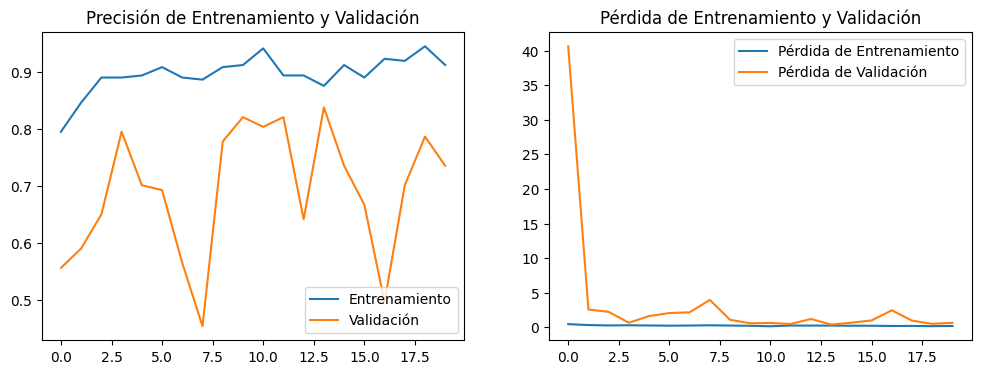

Training with parameters: {'batch_size': 5, 'epochs': 30}
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9100 - loss: 0.1963 - val_accuracy: 0.8632 - val_loss: 0.3890
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9126 - loss: 0.1855 - val_accuracy: 0.7949 - val_loss: 0.7581
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9135 - loss: 0.1918 - val_accuracy: 0.8291 - val_loss: 0.4014
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9267 - loss: 0.1555 - val_accuracy: 0.5897 - val_loss: 1.7085
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9214 - loss: 0.1671 - val_accuracy: 0.7863 - val_loss: 0.4850
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9533 - loss: 0.1202 - val_accuracy: 0.8803 - val_loss: 0.4584
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9350 - loss: 0.1666 - val_accuracy: 0.8376 - val_loss: 0.3827
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accurac

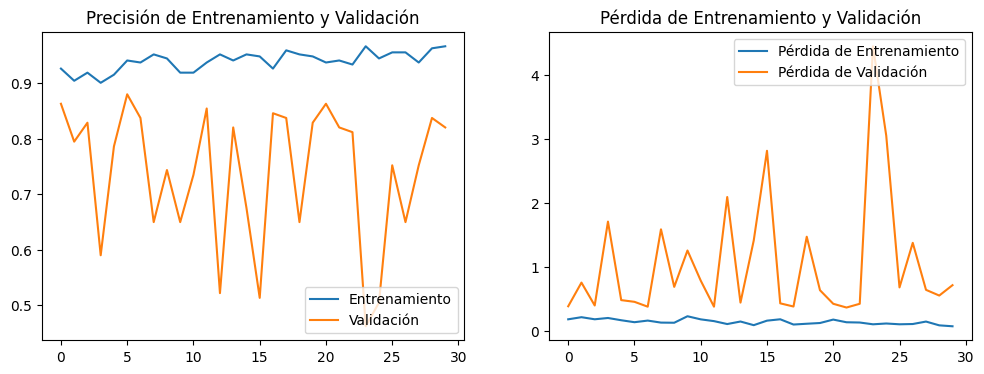

Training with parameters: {'batch_size': 10, 'epochs': 20}
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9839 - loss: 0.0489 - val_accuracy: 0.8718 - val_loss: 0.4236
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9778 - loss: 0.0760 - val_accuracy: 0.8120 - val_loss: 0.4745
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9828 - loss: 0.0504 - val_accuracy: 0.8547 - val_loss: 0.3291
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9712 - loss: 0.0653 - val_accuracy: 0.8205 - val_loss: 0.5670
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9852 - loss: 0.0489 - val_accuracy: 0.7863 - val_loss: 0.7633
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9889 - loss: 0.0445 - val_accuracy: 0.7949 - val_loss: 0.6183
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9779 - loss: 0.0613 - val_accuracy: 0.8376 - val_loss: 0.4168
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step -

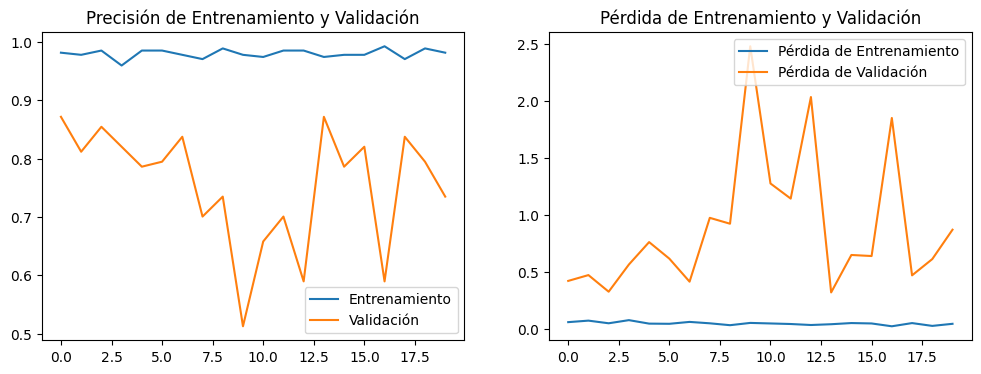

Training with parameters: {'batch_size': 10, 'epochs': 30}
Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9821 - loss: 0.0520 - val_accuracy: 0.8462 - val_loss: 0.4362
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9739 - loss: 0.0741 - val_accuracy: 0.8547 - val_loss: 0.5426
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9857 - loss: 0.0404 - val_accuracy: 0.8547 - val_loss: 0.4006
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9916 - loss: 0.0353 - val_accuracy: 0.8547 - val_loss: 0.3479
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0187 - val_accuracy: 0.8462 - val_loss: 0.3881
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9975 - loss: 0.0260 - val_accuracy: 0.8376 - val_loss: 0.3876
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9836 - loss: 0.0644 - val_accuracy: 0.8632 - val_loss: 0.4011
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step -

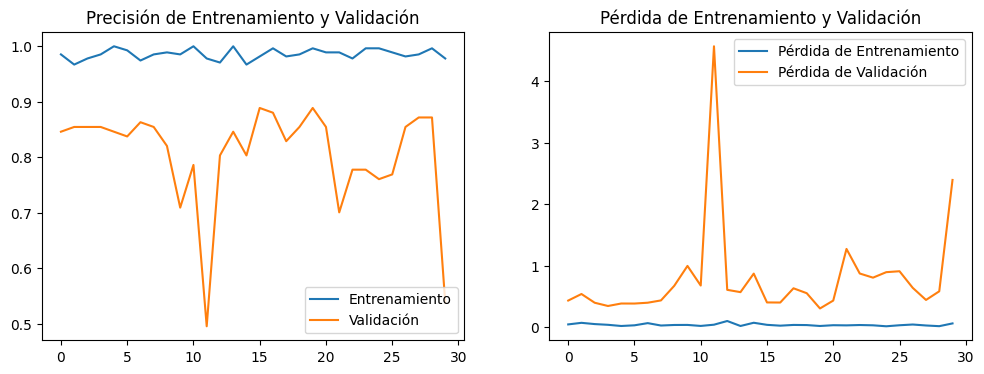

Training sequential model...
Training with parameters: {'batch_size': 5, 'epochs': 20}
Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9699 - loss: 0.0442 - val_accuracy: 0.7436 - val_loss: 1.0105
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9706 - loss: 0.0628 - val_accuracy: 0.8462 - val_loss: 0.5953
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9700 - loss: 0.0645 - val_accuracy: 0.7778 - val_loss: 0.7387
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9488 - loss: 0.0834 - val_accuracy: 0.8462 - val_loss: 0.5633
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9892 - loss: 0.0469 - val_accuracy: 0.7607 - val_loss: 1.0213
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9598 - loss: 0.1163 - val_accuracy: 0.8803 - val_loss: 0.5654
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9648 - loss: 0.0705 - val_accuracy: 0.8718 - val_loss: 0.4322
Epoch 8/20
55/55 ━━━━━━━━━━━━━

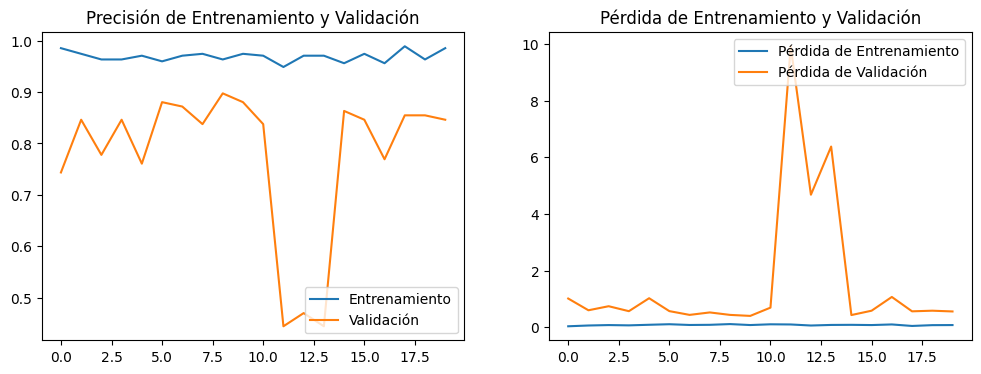

Training with parameters: {'batch_size': 5, 'epochs': 30}
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9767 - loss: 0.0552 - val_accuracy: 0.8803 - val_loss: 0.4344
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9964 - loss: 0.0206 - val_accuracy: 0.6325 - val_loss: 1.9481
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9727 - loss: 0.0863 - val_accuracy: 0.4444 - val_loss: 7.3139
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9768 - loss: 0.0423 - val_accuracy: 0.8291 - val_loss: 0.6448
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9904 - loss: 0.0421 - val_accuracy: 0.8547 - val_loss: 0.5823
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9761 - loss: 0.0810 - val_accuracy: 0.8120 - val_loss: 0.8100
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9842 - loss: 0.0540 - val_accuracy: 0.7863 - val_loss: 0.7997
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accurac

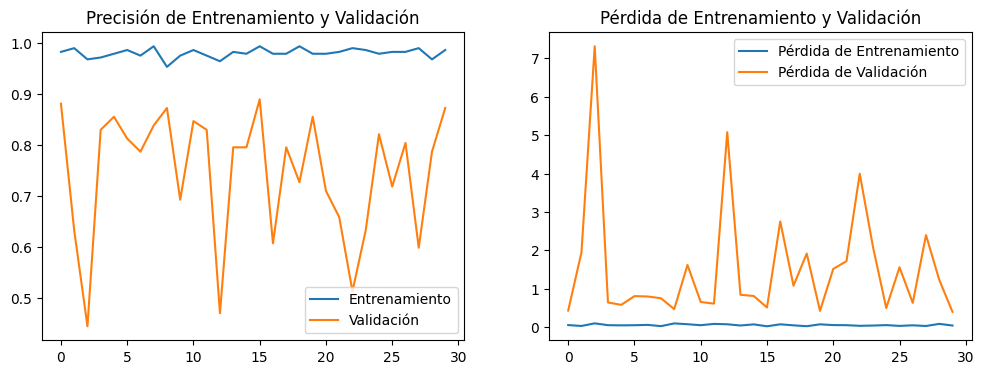

Training with parameters: {'batch_size': 10, 'epochs': 20}
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9969 - loss: 0.0153 - val_accuracy: 0.8889 - val_loss: 0.3556
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9858 - loss: 0.0307 - val_accuracy: 0.8803 - val_loss: 0.5461
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.8632 - val_loss: 0.5695
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9898 - loss: 0.0276 - val_accuracy: 0.8889 - val_loss: 0.3349
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9991 - loss: 0.0102 - val_accuracy: 0.8718 - val_loss: 0.4733
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9771 - loss: 0.0457 - val_accuracy: 0.8547 - val_loss: 0.5034
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.8120 - val_loss: 0.7446
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step -

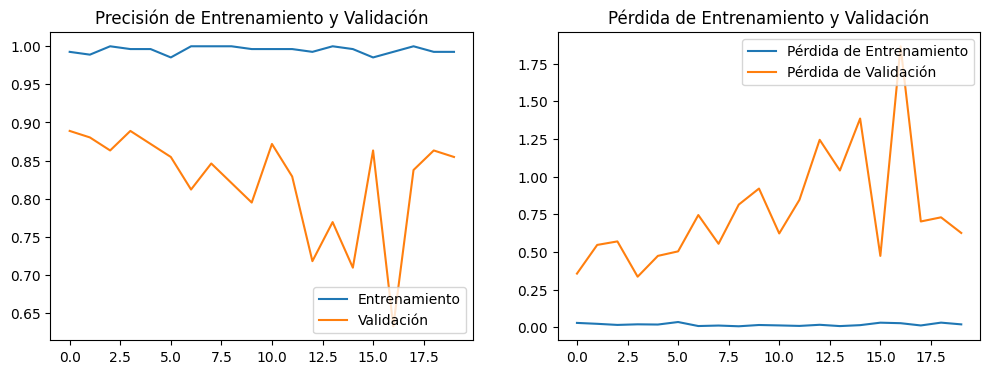

Training with parameters: {'batch_size': 10, 'epochs': 30}
Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.8718 - val_loss: 0.4936
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9927 - loss: 0.0368 - val_accuracy: 0.8547 - val_loss: 0.7151
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9843 - loss: 0.0560 - val_accuracy: 0.6667 - val_loss: 2.1161
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9882 - loss: 0.0294 - val_accuracy: 0.5214 - val_loss: 3.7930
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9898 - loss: 0.0183 - val_accuracy: 0.7094 - val_loss: 1.6017
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.7778 - val_loss: 1.1226
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9858 - loss: 0.0276 - val_accuracy: 0.7863 - val_loss: 1.0115
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step -

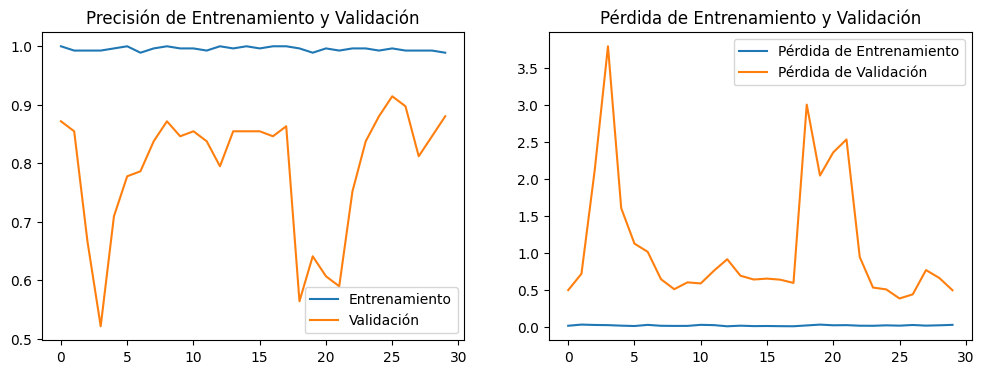

In [ ]:
# Entrenar el modelo

    # --- Parameter Grid for Exploration ---
param_grid = {
        'batch_size': [5,10],
        'epochs': [20,30],
    }

best_accuracy = 0.0
best_model_path = None

    # --- Training Loop (Choose ResNet or Sequential) ---
for model_type in ["resnet", "sequential"]:
        print(f"Training {model_type} model...")
        for params in ParameterGrid(param_grid):
            print(f"Training with parameters: {params}")
            batch_size = params['batch_size']
            epochs = params['epochs']
            history = model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, y_val)
            )
            # Graficar precisión y pérdida
            acc = history.history['accuracy']
            val_acc = history.history['val_accuracy']
            loss = history.history['loss']
            val_loss = history.history['val_loss']

            epochs_range = range(len(acc))


            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(epochs_range, acc, label='Entrenamiento')
            plt.plot(epochs_range, val_acc, label='Validación')
            plt.legend(loc='lower right')
            plt.title('Precisión de Entrenamiento y Validación')

            plt.subplot(1, 2, 2)
            plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
            plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
            plt.legend(loc='upper right')
            plt.title('Pérdida de Entrenamiento y Validación')

            plt.show()


In [ ]:
# Guardar el modelo entrenado
model.save('modelo_cnn_viroide_sanas.h5')
# Ruta a la imagen que deseas probar
image_path = '/content/2018_0101_024500_032.JPG'

# Leer la imagen y redimensionarla al tamaño esperado por el modelo (150x150 en este caso)
img_size = (150, 150)
img = cv2.imread(image_path)
if img is None:
    print(f"Error: Could not load image from {image_path}. Please check the file path and ensure the image exists.")
else:
    img = cv2.resize(img, img_size)

    # Normalizar la imagen (convertir los valores de píxel a rango [0, 1])
    img = img / 255.0

    # Expandir dimensiones para que se ajuste al formato esperado por el modelo (1, 150, 150, 3)
    img = np.expand_dims(img, axis=0)
    # Realizar la predicción
    prediction = model.predict(img)

    # Mostrar el resultado
    if prediction[0] > 0.5:
        print("La hoja está enferma (viroide).")
    else:
        print("La hoja está sana.")

Error: Could not load image from /content/2018_0101_024500_032.JPG. Please check the file path and ensure the image exists.


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 320ms/step - accuracy: 0.8853 - loss: 0.5446
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8657 - loss: 0.5451
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9026 - loss: 0.3184
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8685 - loss: 0.4370
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8157 - loss: 0.6385
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8987 - loss: 0.3741
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9305 - loss: 0.3003
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9201 - loss: 0.2746
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8833 - loss: 0.4237
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8782 - loss: 0.3577
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9158 - loss: 0.2340
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accurac

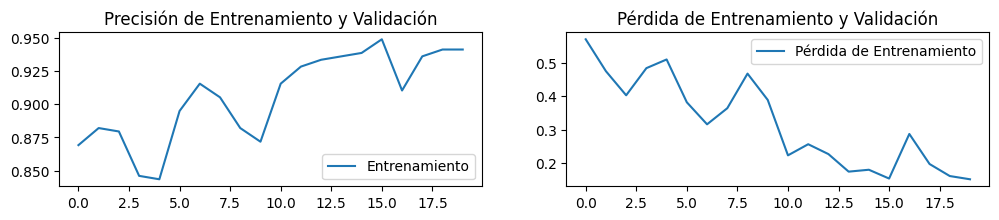

In [ ]:
# Usar todo el dataset para el entrenamiento
X_train = images
y_train = labels

# Recompilar el modelo con el optimizador adam
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Entrenar el modelo con el 100% de los datos
history = model.fit(
    X_train, y_train,
    epochs=20,  # Ajusta el número de épocas según sea necesario
    batch_size=16
)
# Graficar precisión y pérdida
acc = history.history['accuracy']
loss = history.history['loss']


epochs_range = range(len(acc))

plt.figure(figsize=(12, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')

plt.show()



Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 228ms/step - accuracy: 0.9706 - loss: 0.0666
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9748 - loss: 0.0663
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9759 - loss: 0.0625
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9872 - loss: 0.0448
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9862 - loss: 0.0566
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9787 - loss: 0.0599
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9854 - loss: 0.0401
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9860 - loss: 0.0435
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9870 - loss: 0.0377
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9831 - loss: 0.0604
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9839 - loss: 0.0373
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accurac

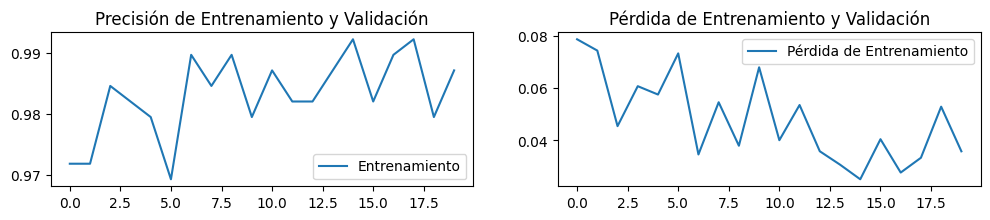

In [ ]:
# Usar todo el dataset para el entrenamiento
X_train = images
y_train = labels

# Recompilar el modelo con el optimizador sgd
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Entrenar el modelo con el 100% de los datos
history = model.fit(
    X_train, y_train,
    epochs=20,  # Ajusta el número de épocas según sea necesario
    batch_size=16
)
# Graficar precisión y pérdida
acc = history.history['accuracy']
loss = history.history['loss']


epochs_range = range(len(acc))

plt.figure(figsize=(12, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')

plt.show()



Found 0 images belonging to 0 classes.


Loading model: model_1_lr0.001_optadam.h5
Training with optimizer: adam
Training with optimizer: sgd
24/24 - 1s - 43ms/step - accuracy: 0.4444 - loss: 1.0479
Loaded model model_1_lr0.001_optadam.h5 - Test Loss: 1.0479, Test Accuracy: 0.4444
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


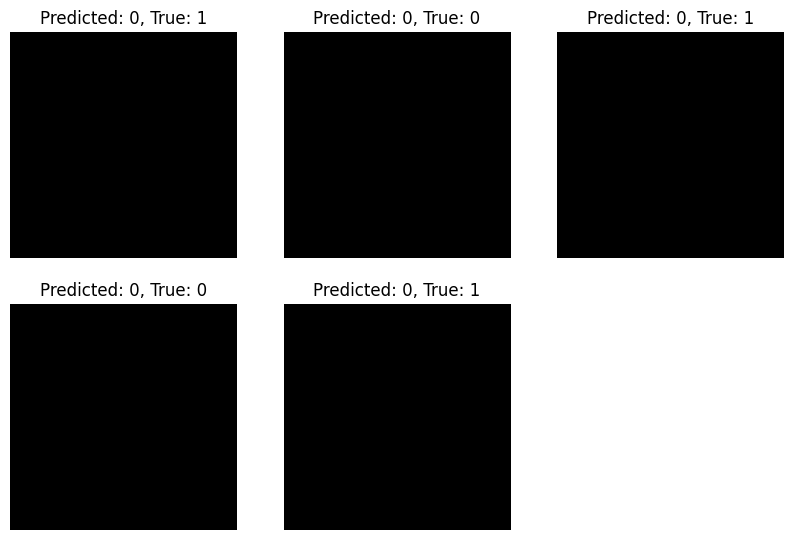

Model: model_1_lr0.001_optadam.h5


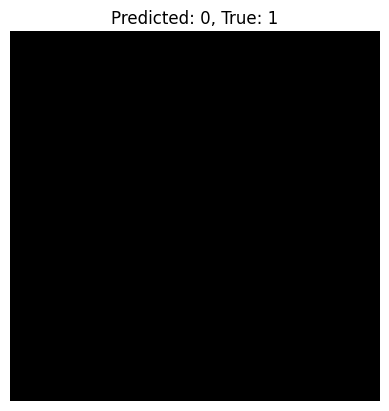

Image 1. Is this prediction correct (y/n)? n


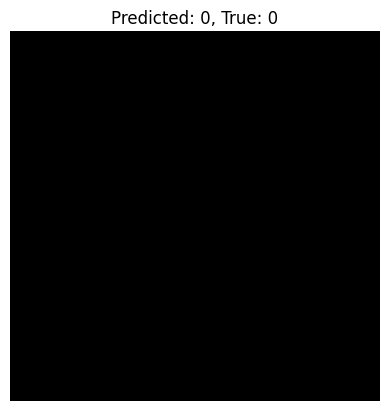

Image 2. Is this prediction correct (y/n)? y


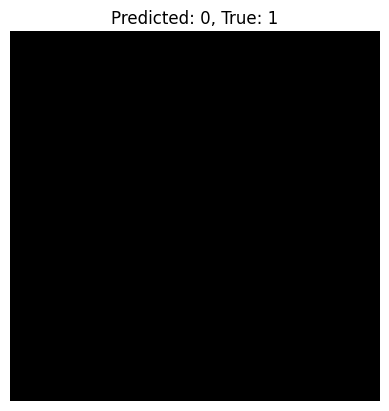

Image 3. Is this prediction correct (y/n)? n


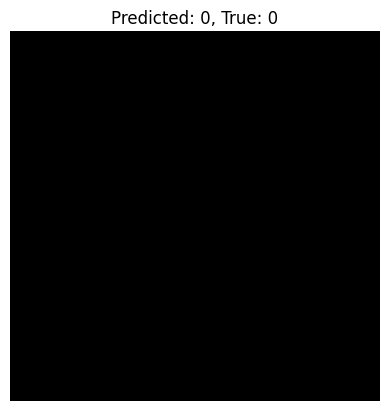

Image 4. Is this prediction correct (y/n)? y


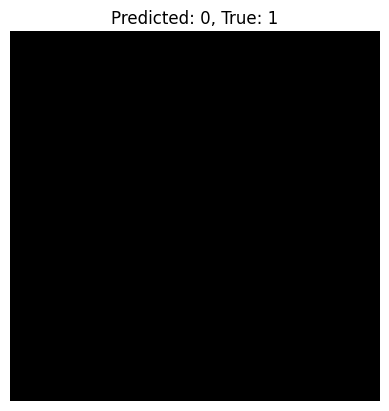

Image 5. Is this prediction correct (y/n)? n
Enter the correct class (0 or 1): 1


------------------------------
Loading model: model_1_lr0.001_optsgd.h5
Training with optimizer: adam
Training with optimizer: sgd
24/24 - 1s - 35ms/step - accuracy: 0.4444 - loss: 0.6933
Loaded model model_1_lr0.001_optsgd.h5 - Test Loss: 0.6933, Test Accuracy: 0.4444
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


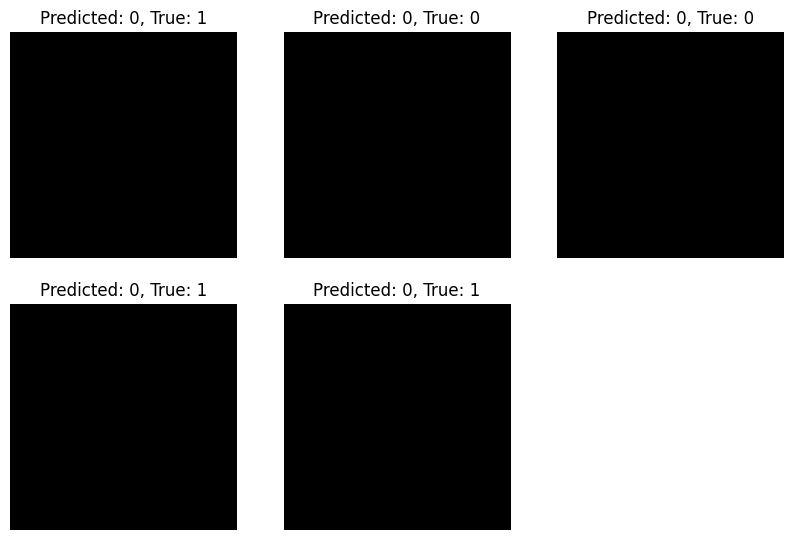

Model: model_1_lr0.001_optsgd.h5


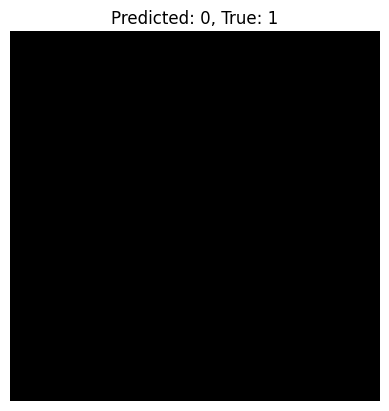

Image 1. Is this prediction correct (y/n)? n


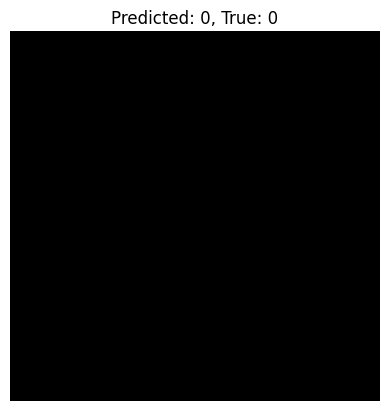

Image 2. Is this prediction correct (y/n)? y


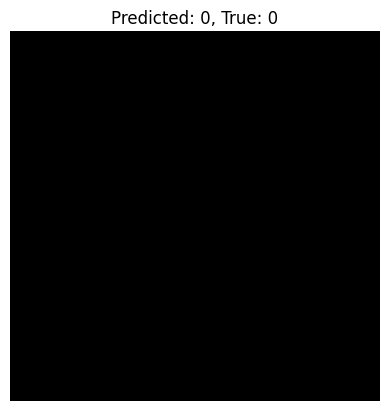

Image 3. Is this prediction correct (y/n)? y


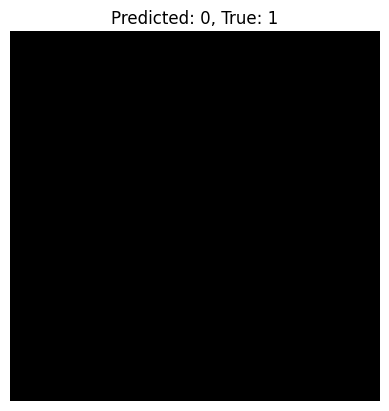

Image 4. Is this prediction correct (y/n)? n


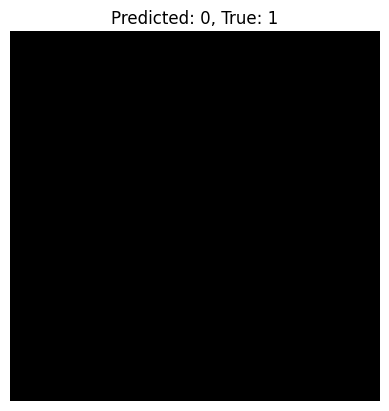

Image 5. Is this prediction correct (y/n)? n
Enter the correct class (0 or 1): 0


------------------------------
Loading model: model_1_lr0.0001_optadam.h5
Training with optimizer: adam
Training with optimizer: sgd
24/24 - 1s - 34ms/step - accuracy: 0.4444 - loss: 0.7172
Loaded model model_1_lr0.0001_optadam.h5 - Test Loss: 0.7172, Test Accuracy: 0.4444
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


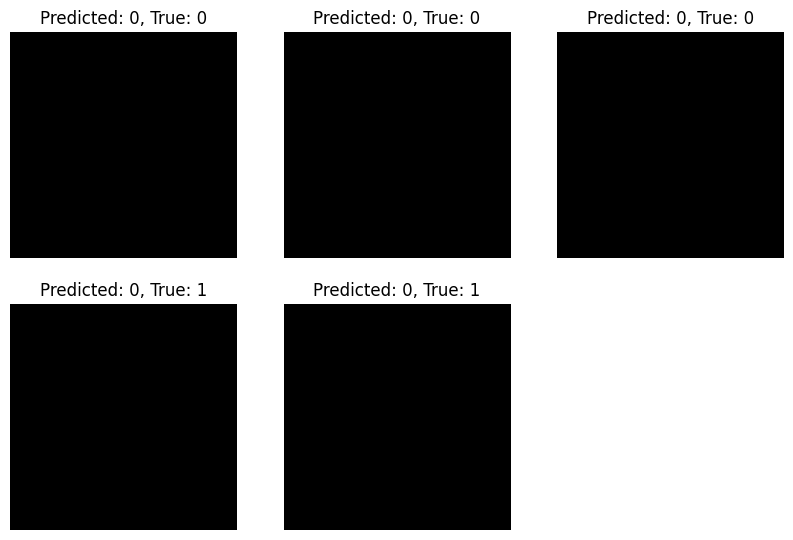

Model: model_1_lr0.0001_optadam.h5


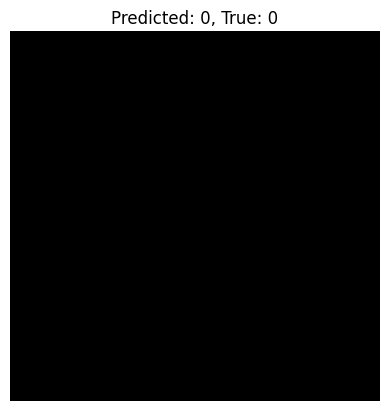

Image 1. Is this prediction correct (y/n)? y


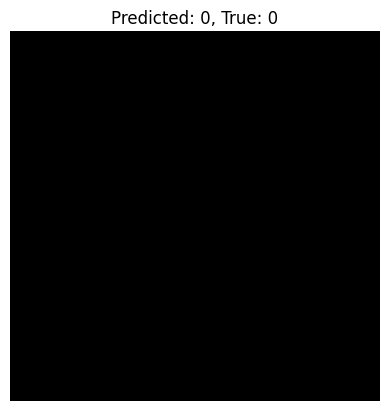

Image 2. Is this prediction correct (y/n)? y


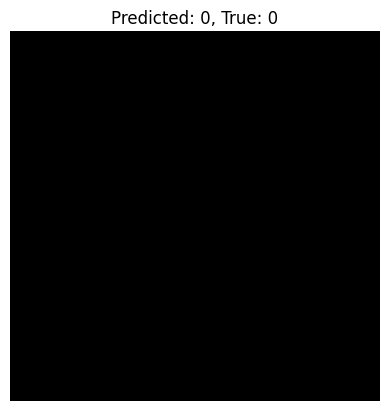

Image 3. Is this prediction correct (y/n)? y


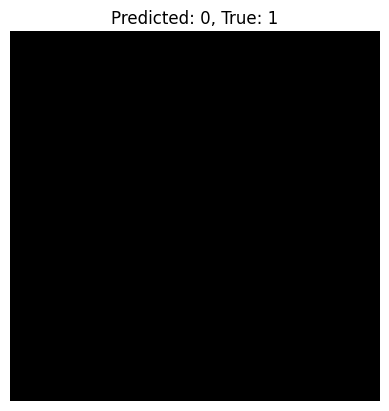

Image 4. Is this prediction correct (y/n)? n


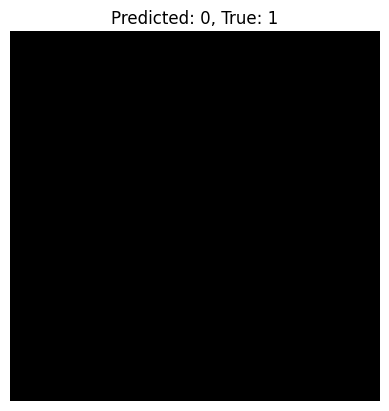

Image 5. Is this prediction correct (y/n)? n
Enter the correct class (0 or 1): 1


------------------------------
Loading model: best_model_1_model.h5
Training with optimizer: adam
Training with optimizer: sgd
24/24 - 1s - 34ms/step - accuracy: 0.4444 - loss: 0.6932
Loaded model best_model_1_model.h5 - Test Loss: 0.6932, Test Accuracy: 0.4444
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


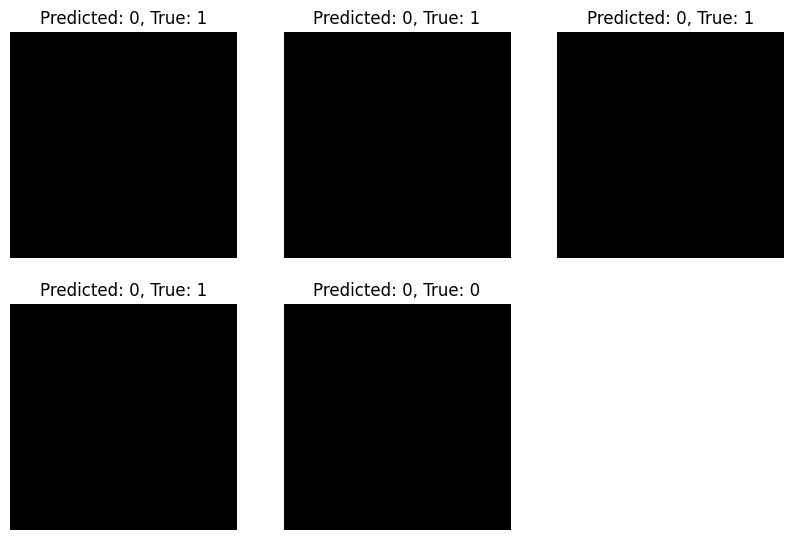

Model: best_model_1_model.h5


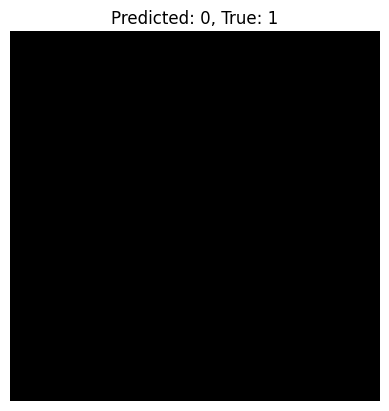

KeyboardInterrupt: Interrupted by user

In [ ]:
# Cargar modelos entrenados para el ciclo de retroalimentación supervisada
saved_model_paths = [f for f in os.listdir(MODEL_SAVE_PATH) if f.endswith('.h5')]
optimizers_to_test = ['adam', 'sgd']


model_types = ['model_1', 'model_2']
# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale images
test_generator = test_datagen.flow_from_directory(
    viroide_dir,
    target_size=(150, 150),  # Match your model's input size
    batch_size=32,           # Adjust as needed
    class_mode='categorical',     # For binary classification ('categorical' for multi-class)
    shuffle=False             # Important for feedback loop: keep images in a predictable order
)


for model_path in saved_model_paths:
    print(f"Loading model: {model_path}")
    loaded_model = keras.models.load_model(os.path.join(MODEL_SAVE_PATH, model_path))
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
    test_datagen = ImageDataGenerator(rescale=1./255)

        # Assuming 'X_train', 'y_train', 'X_val', 'y_val' are your training and validation data
    train_generator = train_datagen.flow(
            X_train, y_train,
            batch_size=param_grid['batch_size'][0]  # Access batch_size from param_grid
        )

    test_generator = test_datagen.flow(
            X_val, y_val,
            batch_size=param_grid['batch_size'][0]  # Access batch_size from param_grid
        )

    for optimizer in optimizers_to_test:
            print(f"Training with optimizer: {optimizer}")
            # entrenamiento y evaluación
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


    loss, accuracy = loaded_model.evaluate(test_generator, verbose=2)
    print(f"Loaded model {model_path} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

        # Predicciones y visualización
    predictions = loaded_model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Reset the generator to get images and labels from the beginning
    test_generator.reset()
    test_images, true_labels_batch = next(test_generator)
    test_images = test_images.astype(np.uint8)  # Convert to uint8

    # Limit the number of images to display based on available labels
    num_images_to_display = min(9, len(true_labels_batch))

    plt.figure(figsize=(10, 10))
    for i in range(num_images_to_display):
                plt.subplot(3, 3, i + 1)
                plt.imshow(test_images[i])
                plt.title(f"Predicted: {predicted_classes[i]}, True: {true_labels_batch[i]}")
                plt.axis("off")
    plt.show()

            # Feedback (using same batch for demonstration)
    print(f"Model: {model_path}")

            # Ensure loop iterates through the minimum of predictions, available images and available true labels
    num_feedback_images = min(len(predicted_classes), len(test_images), len(true_labels_batch))

    for i in range(num_feedback_images):
                original_image_path = test_generator.filepaths[i]
                original_image = cv2.imread(original_image_path)
                original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) # Convert to RGB
                plt.imshow(original_image)
                plt.title(f"Predicted: {predicted_classes[i]}, True: {true_labels_batch[i]}")
                plt.axis("off")
                plt.show()

                feedback = input(f"Image {i + 1}. Is this prediction correct (y/n)? ").lower()
    if feedback == 'n':
                    correct_class = int(input(f"Enter the correct class (0 or 1): "))
                    # TODO: reentrenar!

    print("-" * 30)

#ResNet

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input

# Definir la entrada
input_tensor = Input(shape=(150, 150, 3))

# Cargar el modelo ResNet50 preentrenado con los pesos de ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Congelar las capas del modelo base
base_model.trainable = False

# Añadir capas adicionales al modelo
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Global pooling en lugar de Flatten
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)  # Para una tarea de clasificación binaria

# Definir el modelo completo
model = models.Model(inputs=input_tensor, outputs=output)

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


KeyboardInterrupt: 

#RedNormal

In [ ]:
# Definir el modelo CNN con Batch Normalization
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),  # Añadir Batch Normalization después de la capa Conv2D
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])


from keras.optimizers import Adam
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Mostrar resumen del modelo
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 15, 15, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,454,529 (13.18 MB)

 Trainable params: 3,453,825 (13.18 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val)
)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.5303 - loss: 4.2329 - val_accuracy: 0.5556 - val_loss: 0.9482
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.7936 - loss: 0.8984 - val_accuracy: 0.5556 - val_loss: 1.8618
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.7472 - loss: 0.9202 - val_accuracy: 0.5556 - val_loss: 3.4305
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8050 - loss: 0.9365 - val_accuracy: 0.5556 - val_loss: 4.6689
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8319 - loss: 0.5015 - val_accuracy: 0.5556 - val_loss: 3.7877
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8600 - loss: 0.4122 - val_accuracy: 0.5556 - val_loss: 3.5395
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.8489 - loss: 0.3773 - val_accuracy: 0.5556 - val_loss: 3.2954
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.8683 - loss: 0.2867 - val_accuracy: 0.5556 - val_loss: 3.0809
Epoch 9/

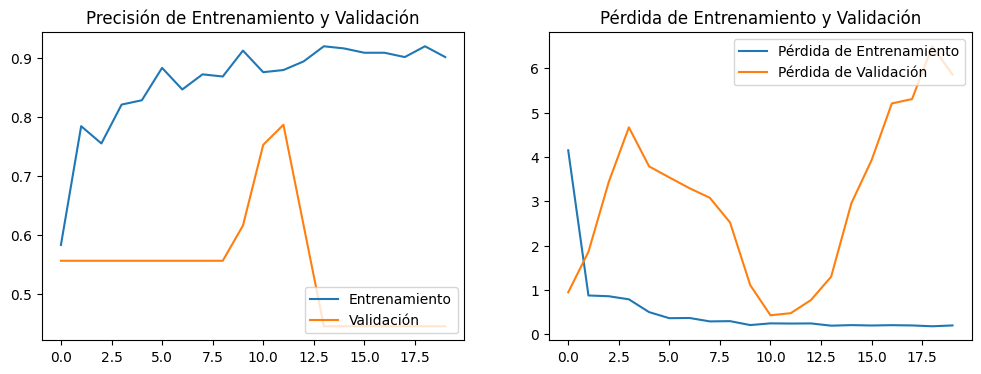

In [ ]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')

plt.show()


In [ ]:
# Guardar el modelo entrenado
model.save('modelo_cnn_viroide_sanas.h5')


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Cargar el modelo previamente entrenado
model = load_model('modelo_cnn_viroide_sanas.h5')

In [ ]:
# Cargar el modelo previamente entrenado
model = load_model('modelo_cnn_viroide_sanas.h5')

In [ ]:
# Ruta a la imagen que deseas probar
image_path = '/content/2018_0101_024500_032.JPG'

# Leer la imagen y redimensionarla al tamaño esperado por el modelo (150x150 en este caso)
img_size = (150, 150)
img = cv2.imread(image_path)
img = cv2.resize(img, img_size)

# Normalizar la imagen (convertir los valores de píxel a rango [0, 1])
img = img / 255.0

# Expandir dimensiones para que se ajuste al formato esperado por el modelo (1, 150, 150, 3)
img = np.expand_dims(img, axis=0)


In [ ]:
# Realizar la predicción
prediction = model.predict(img)

# Mostrar el resultado
if prediction[0] > 0.5:
    print("La hoja está enferma (viroide).")
else:
    print("La hoja está sana.")


In [ ]:
# Ya es necesario dividir los datos
# X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

# Usar todo el dataset para el entrenamiento
X_train = images
y_train = labels


In [ ]:

# Recompilar el modelo para evitar el error con el optimizador
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Entrenar el modelo con el 100% de los datos
history = model.fit(
    X_train, y_train,
    epochs=20,  # Ajusta el número de épocas según sea necesario
    batch_size=16
)


In [ ]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
loss = history.history['loss']


epochs_range = range(50)

plt.figure(figsize=(12, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')

plt.show()
